# TUTORIAL

# Implement Date-reuploading classifier in Qiskit Machine Learning

## 1. Introduction 

The data re-uploading , "**re-uploading**" refers to the process of repeatedly encoding the input data into the quantum state. The input data is re-uploaded into the quantum circuit at multiple layers or stages of the network. 




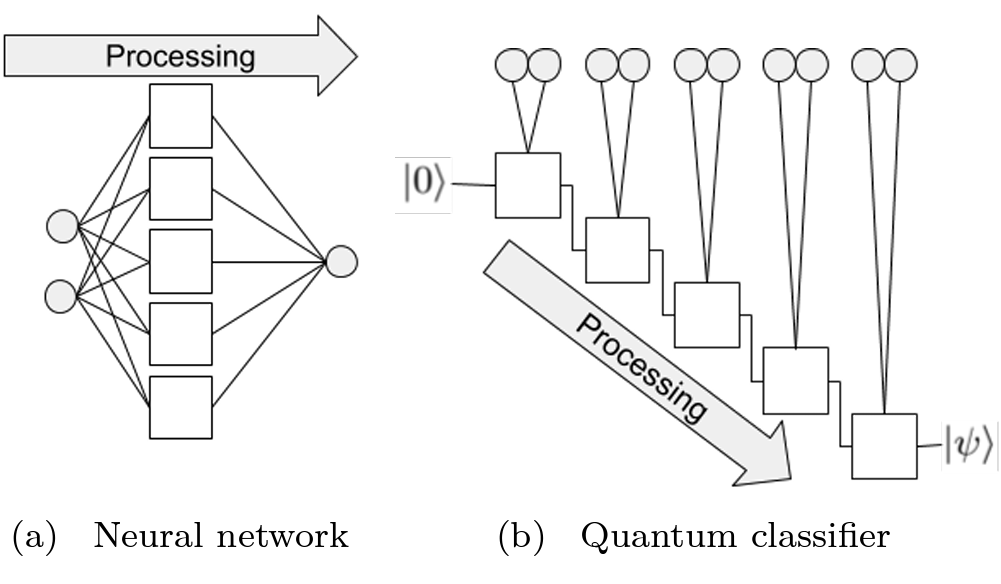

**Figure 1**: *Simplified working schemes of a neural network and a single-qubit quantum classifier with data re-uploading. Image taken from the reference ([1](https://arxiv.org/abs/1907.02085))*


## 2.  Encoding the Data

A product of free single-qubit unitaries can be written with another single-qubit unitary 

**$U(\vec{\varphi}_1) \ldots U(\vec{\varphi}_n) \equiv U(\vec{\varphi})$**

But , it is insufficient to carry out any non-trivial task

So we need to adopt technique called **data re-uploading**. If we add some fixed parameter dependency, the operation becomes flexible and data-depedent.

**$U(\vec{\varphi}, \vec{x}) \equiv U(\vec{\varphi}_N)U(\vec{x}) \ldots U(\vec{\varphi}_1)U(\vec{x})$**


## 3. Data Reuploading Layers

### Single Qubit Classifier

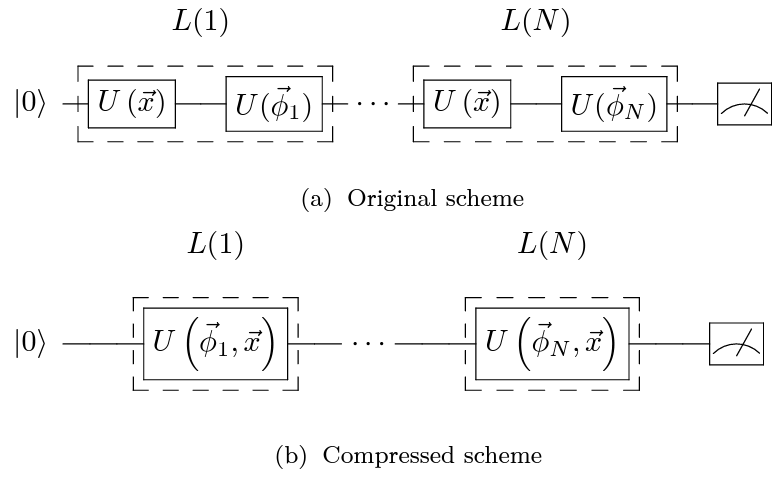
**Figure 2**: *Single-qubit classifier with data re-uploading.The quantum circuit is divided into layer gates L(i),which constitutes the classifier building blocks.In the upper circuit, each of these layers is composed of a U ($\vec{x}$) gate,which uploads the data,and a parametrized unitary gate U ($\vec{Φ}$). Image taken from the reference ([1](https://arxiv.org/abs/1907.02085))*

**Layers**

The final classification of patterns will come from the results of measurements on  $|\psi\rangle$.  We need to introduce the concept of processing layer as the combination of 

$\boxed{ L(i) \equiv U(\vec{\varphi}_i)U(\vec{x})} $

This will equivalent to the below structure:

**$\boxed{U(\vec{\varphi}, \vec{x}) = L(N) L(N-1) \ldots L(2)L(1)}$**


Then,a layer would only need a single rotation to introduce data and tunable parameters,$L(i) = U(\vec{\phi}, \vec{x})$.In addition,each data point can be uploaded with some weight **$ w_i$**.

**$ L(i) = U(\vec{\phi}, \vec{x})$** -----> **U($\vec{\theta}_i $ + $\vec{w}$ $\cdot$ $\vec{x}$)**

$\boxed{L(i) = U(\vec{\theta}^{(k)}_i + \vec{w}^{(k)}_i\cdot \vec{x}^{(k)}).......  U(\vec{\theta}^{(1)}_i + \vec{w}^{(1)}_i \cdot \vec{x}^{(1)})}$

$U(\theta) = R_x(\theta_x)R_y(\theta_y)R_z(\theta_z) \vec{\theta}$

where $\theta = (\theta_x, \theta_y, \theta_z) \vec{w}$, $w = (w_x, w_y, w_z)$, $\vec{x}$ represents the input data, $N$ represents the number of layers.

### Multi Qubit Quantum Classifier

We need to introduce **entanglement** (therefore, more qubits) to eventually prove any quantum advantage.

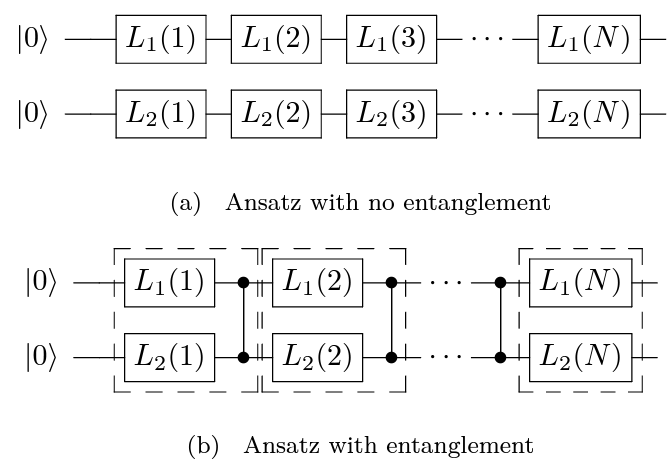
**Figure 3** : *Two-qubit quantum classifier circuit without entanglement(topcircuit)and with entanglement(bottom circuit).Here, each layer includes a rotation with data reuploading in both qubits plus a CZgate if there is entanglement.The exception is the last layer,which does not have any CZ gate associated to it.Image taken from the reference ([1](https://arxiv.org/abs/1907.02085))*

Structure:

**$\boxed {U(\vec{\phi}, \vec{x}) = L(N) \ E \ L(N-1) \ E \ \ldots \, E \ L(2) \ E \ L(1)}$**

NOTE: *Linear Entanglement*


## 4.Training/Optimization



**Training** and **Optimization** of the quantum circuit require careful consideration of the framework and integration with Qiskit Machine Learning's Quantum Neural Network (`QNN`) implementation. In this scenario, `PyTorch` is chosen as the training framework, and it is integrated with Qiskit using the `TorchConnector` feature.

By utilizing `PyTorch`, we can leverage its extensive functionality to train and optimize the quantum circuit effectively.

Qiskit Machine Learning offers the `EstimatorQNN` and `SamplerQNN` components, specifically designed for working with quantum neural networks. 

The `TorchConnector` feature in `Qiskit` serves as a bridge between `PyTorch` and `Qiskit`, facilitating the integration process. It allows us to use `PyTorch` as the underlying framework for **training** and **optimization** while taking advantage of the `QNN` implementation provided by **Qiskit Machine Learning**. 


--------------------------------------------------------------------------------------------------------------------------------

In [1]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

--------------------------------------------------------------------------------------------------------------------------------

### Set up

The code provided defines a class called `DataReuploading` which represents a quantum circuit ansatz, and contains **rotational** and **entanglement** layers alternatively.The constructor takes three parameters: `num_qubits`, `num_features`, and `num_layers`.

The number of features (`num_features`) is rounded up to the nearest multiple of 3 . This ensures that the number of features is divisible by 3, which is a requirement for the **rotational** gate layer.

Two ParameterVector objects are created: `self.parameters` and `self.input_params`. 

`self.parameters` represents the *trainable* parameters of the circuit. 

`self.input_params` represents the *input* parameters of the circuit.



In [2]:
class DataReuploading():
    """
    Create the Data Reuploading Classifier ansatz.

    
    """

    def __init__(
        self,
        num_qubits: int = None,
        num_features: int  = None,
        num_layers: int = None
    ):
        """
        Args:
            num_qubits: The number of qubits.
            num_features: The number of input features (the dimension of the input data).
            num_layers: The number of layers (N).
        Returns:
            ansatz: A QuantumCircuit object.
        """

        self._num_qubits = num_qubits
        # rounding up the number of features to the nearest integer number that is multiples of 3
        self._num_features = int(np.ceil(num_features/3)*3)
        self._num_layers = num_layers

        self.parameters = ParameterVector(name="θ", length=2*self._num_qubits*self._num_features*self._num_layers)
        self.input_params = ParameterVector(name="x", length=self._num_features)

        qc = QuantumCircuit(self._num_qubits)
        for l in range(self._num_layers):
            for k in range(int(np.ceil(num_features/3))):
                for q in range(self._num_qubits):
                    qc.compose(self.rotational_gate_layer(self._num_qubits, q, self.parameters[l*self._num_qubits*int(np.ceil(num_features/3))*2*3 + q*int(np.ceil(num_features/3))*2*3 + k*2*3 : l*self._num_qubits*int(np.ceil(num_features/3))*2*3 + q*int(np.ceil(num_features/3))*2*3 + k*2*3 + 2*3], self.input_params[k*3 : k*3+3]), inplace=True)

            qc.barrier()
          
          # if it's not the last layer, add the entanglement
            if (l+1) != self._num_layers and self._num_qubits != 1:
                qc.compose(self.entanglement_layer(self._num_qubits), inplace=True)
                qc.barrier()

        self.circuit = qc
        
                    
    def rotational_gate_layer(
        self,
        num_qubits: int = None,
        qubit_id: int = None,
        trainable_params : ParameterVector = None,
        input_params : ParameterVector  = None
    ):
        circuit_block = QuantumCircuit(num_qubits)
        circuit_block.rx(trainable_params[0] + trainable_params[3]*input_params[0], qubit_id)
        circuit_block.ry(trainable_params[1] + trainable_params[4]*input_params[1], qubit_id)
        circuit_block.rz(trainable_params[2] + trainable_params[5]*input_params[2], qubit_id)

        return circuit_block
    def entanglement_layer(
        self,
        num_qubits: int = None
    ):
        circuit_block = QuantumCircuit(num_qubits)

        # Apply CZ gates between adjacent qubits linearly
        for i in range(num_qubits - 1):
            circuit_block.cz(i, i + 1)


        return circuit_block
    

    @property
    def num_qubits(self) -> int:
        """Returns the number of qubits used by the ansatz."""
        return self._num_qubits

    @property
    def num_features(self) -> int:
        """Returns the number of features of the input data accepted by the ansatz."""
        return self._num_features

    @property
    def num_layers(self) -> int:
        """Returns the number of layers used by the ansatz."""
        return self._num_layers
     

        


        
        



# Dataset Generation

Generating and visualizing the circle pattern datasets using sklearn datasets([here](https://scikit-learn.org/stable/datasets/sample_generators.html)) and can be used for further analysis for machine learning models. 

*note:noise parameter 0.0*

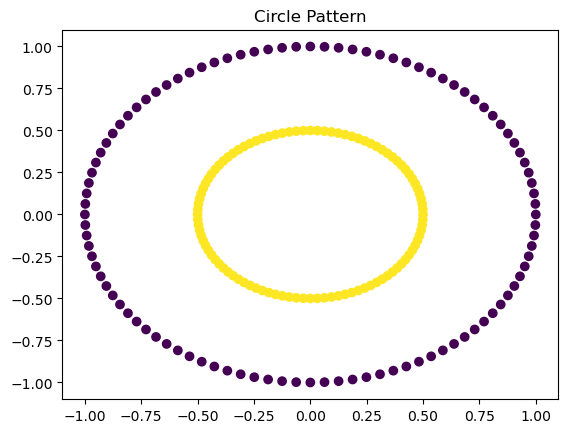

In [3]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generate a dataset with a circle pattern
X_circle, y_circle = make_circles(n_samples=200, noise=0.0, factor=0.5)

# Plot the circle pattern
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle)
plt.title('Circle Pattern')
plt.show()
     

In [4]:
# zero padding

X_circle = np.pad(X_circle, ((0, 0), (0, 1)))

# convert to torch Tensors

X_circle = Tensor(X_circle)
y_circle = Tensor(y_circle).reshape(len(y_circle), 1)



# Train-Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_circle, y_circle, test_size=0.2, random_state=42)


y_train01 = Tensor(y_train).reshape(len(y_train))
X_train.shape, y_train.shape, X_test.shape, y_test.shape , y_train01.shape 

(torch.Size([160, 3]),
 torch.Size([160, 1]),
 torch.Size([40, 3]),
 torch.Size([40, 1]),
 torch.Size([160]))

##  Let's check how well the prepared DataReuploading class is working.

*Example: let's take the `num_qubits` and `num_features` **2** and the `num_layers` **9** and passed these three parameters to the constructed `DataReuploading` class*.




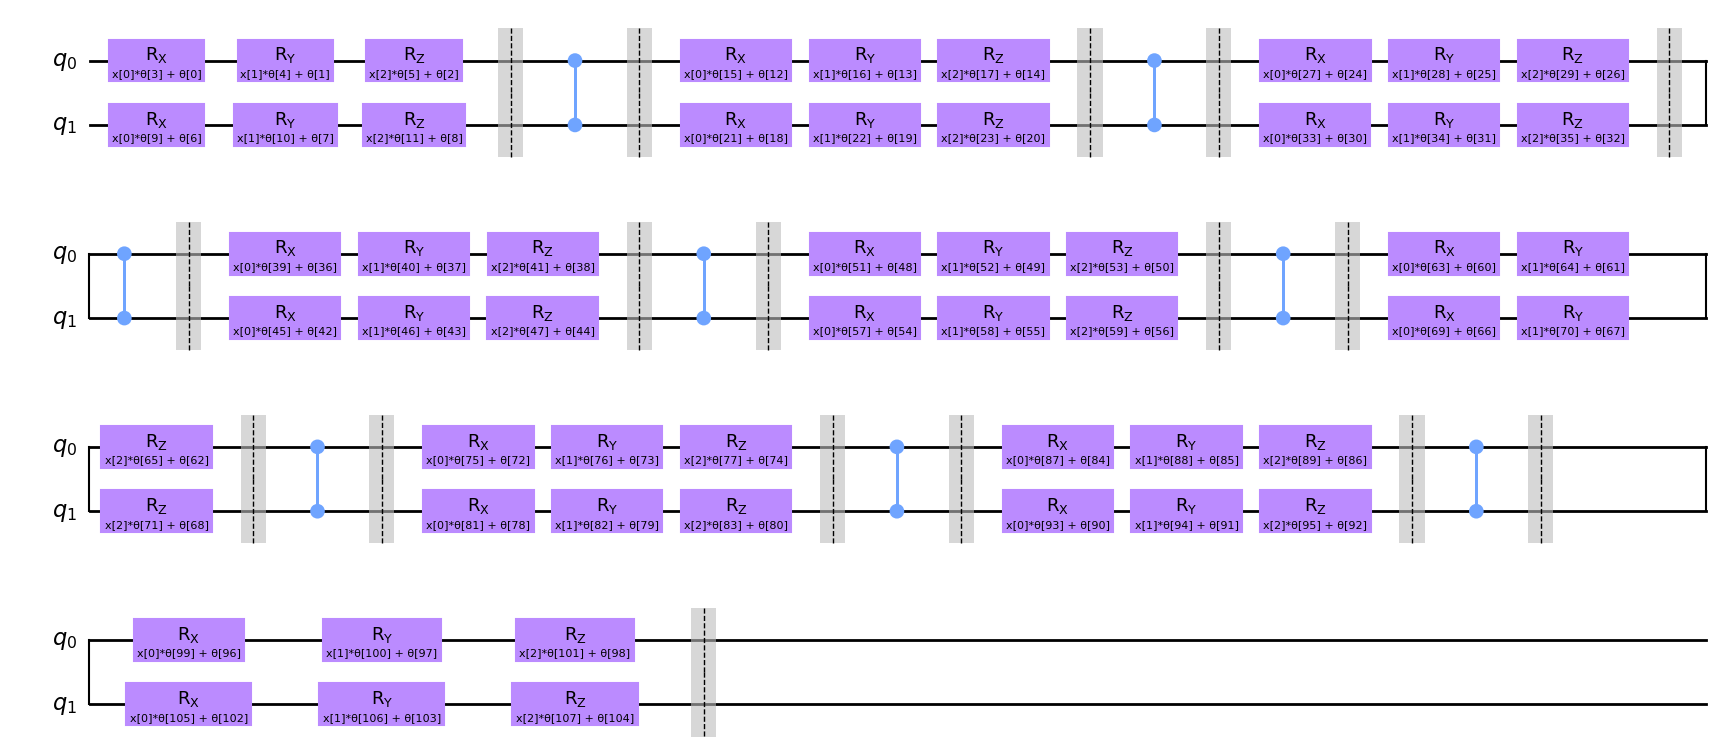

In [5]:
DRC = DataReuploading(num_qubits=2, num_features=2, num_layers = 9)
DRC.circuit.draw('mpl')
     

--------------------------------------------------------------------------------------------------------------------------------

# Classification with Estimator QNN / Sampler QNN and pytorch

*Integration with QNN implementation of Qiskit Machine Learning (`EstimatorQNN` and `SamplerQNN`)*

*Used `TorchConnector` feature of Qiskit.Connects a Qiskit (Quantum) Neural Network to `PyTorch`.*

**Estimator QNN**

In [6]:
# Setup QNN
qnn1 = EstimatorQNN(
    circuit=DRC.circuit, input_params=DRC.input_params, weight_params=DRC.parameters
)

# Set up PyTorch module
model1 = TorchConnector(qnn1)
     

# Test with a single input
model1(X_train[0, :])
     

tensor([0.6147], grad_fn=<_TorchNNFunctionBackward>)

In [7]:

# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_train), y_train)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

49.51571273803711
36.08623123168945
24.9346866607666
26.76576805114746
12.875452995300293
10.740562438964844
7.955015182495117
6.020380973815918
4.713078498840332
3.9996087551116943
3.3921408653259277
2.8623194694519043
2.5865378379821777
2.2231757640838623
1.5752922296524048
1.9049632549285889
1.116324543952942
1.0402249097824097
0.9560691118240356
0.8304160833358765


tensor(49.5157, grad_fn=<MseLossBackward0>)

Accuracy: 0.875


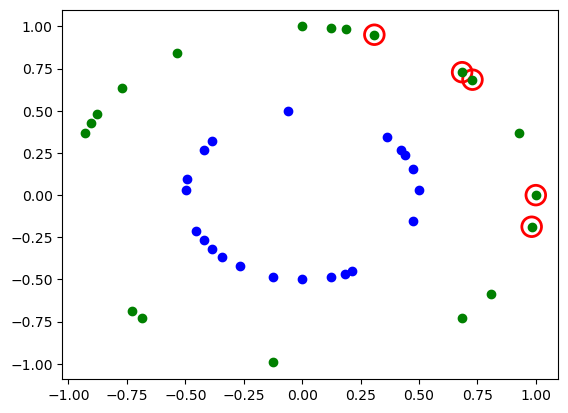

In [8]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X_test, y_test):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y_test.numpy().reshape(-1,)*2-1) / len(y_test))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test.numpy().reshape(-1,)*2-1, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

plt.show()

**Sampler QNN**

In [9]:
y_train01 = y_train01.long() 

In [10]:
qnn2 = SamplerQNN(
    circuit=DRC.circuit, input_params=DRC.input_params, weight_params=DRC.parameters
    
)
model2 = TorchConnector(qnn2)

In [13]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_train), y_train01)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

1.4023065567016602
1.36484694480896
1.4456677436828613
1.4079097509384155
1.319462537765503
1.362990140914917
1.2540619373321533
1.2891684770584106
1.1489008665084839
1.1184463500976562
1.081809401512146
1.0144281387329102
0.9817455410957336
0.9635218381881714
0.9541428685188293
0.9275864362716675
0.9190753102302551
0.9020005464553833
0.8918275833129883
0.8830900192260742


Accuracy: 0.525


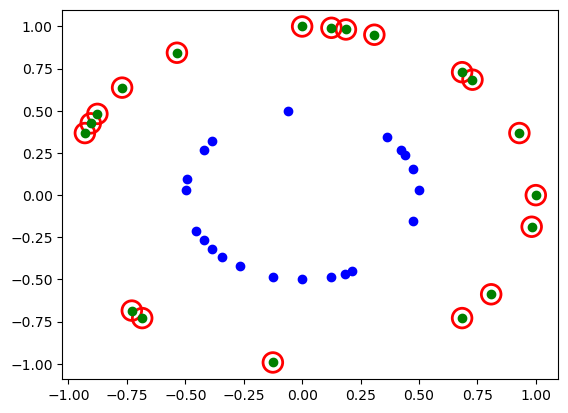

In [16]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X_test, y_test):
    output = model2(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y_test.numpy().reshape(-1,)*2-1) / len(y_test))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test.numpy().reshape(-1,)*2-1, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

plt.show()

--------------------------------------------------------------------------------------------------------------------------------

# Reference

**[1]** *Pérez-Salinas et al.Data re-uploading for a universal quantum classsifier,(2019)[https://arxiv.org/abs/1907.02085]*



# Conclusion

In this tutorial, we prepared a Data re-uploading(ansatz) class, which uses a quantum circuit with a series of data re-uploading and processing layers. Unlike the conventional quantum circuit of quantum neural network, it has multiple layers of re-uploading input data. We implemented the data re-uploading quantum neural network in Qiskit Machine Learning.

We now encourage you to play around and see how different numbers of `qubits`, `features`, and `layers` parameters and evaluate the performance of the model with different datasets.